# Note
This notebook can be run on google colab for improved performance. The code changes necessary for running on this system are commented over the code.

## Data preprocessing

In [ ]:
! pip install \
  scprep\
  spacy==2.3.2 \
  sentence_transformers==0.4.0 \
  phate==1.0.4 && \
  python -m spacy download es_core_news_lg

<span style="color:red"><strong>WARNING!</strong></span> Once you installed the packages in the previous cell you must restart your runtime and then import the library and load the model

In [1]:
import spacy
if spacy.prefer_gpu():
    print("Using the GPU")
else:
    print("Using the CPU")
es_nlp = spacy.load('es_core_news_lg')

Using the GPU


For development work, in case you want to update the files in your GitHub branch by rerunning the clone, you first have to empty the folder.

In [2]:
!rm -rf policy-data-analyzer/

In [3]:
# Define branch to clone
! branch_name='#50_dfq_sbert_fine_tuning' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

Cloning into 'policy-data-analyzer'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 3093 (delta 94), reused 129 (delta 51), pack-reused 2919
Receiving objects: 100% (3093/3093), 134.22 MiB | 18.57 MiB/s, done.
Resolving deltas: 100% (1641/1641), done.
Checking out files: 100% (843/843), done.


In [4]:
import pandas as pd
import sys
import os
import csv
from sklearn.model_selection import train_test_split
from sentence_transformers import SentencesDataset, SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import LabelAccuracyEvaluator
from torch import nn, Tensor
from typing import Iterable, Dict
from torch.utils.data import DataLoader
import math
import time
import cupy as cp

# os.chdir("policy-data-analyzer") #If you run this cell more than once, comment out this line because you are ready in this folder and you will get an error
from tasks.data_loader.src.utils import *
from tasks.data_augmentation.src.zero_shot_classification.latent_embeddings_classifier import *
from tasks.evaluate_model.src.model_evaluator import *
from tasks.data_visualization.src.plotting import *

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fine-tuning the embedding model on the labeled data

### Something we can try out:
https://www.sbert.net/examples/training/data_augmentation/README.html#extend-to-your-own-datasets

### Links:
https://github.com/UKPLab/sentence-transformers/issues/350

https://omoindrot.github.io/triplet-loss

### Possible tasks for fine-tuning:
1) Given a pair of sentence embeddings, do they belong to the same category (binary)?

2) Given a sentence and a category embedding, does the sentence belong to the category (binary)?

3) Given a sentence embedding, use a classifier to predict its category (multiclass) [https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/nli/training_nli.py](https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/nli/training_nli.py)

4) Use a triplet loss approach such that sentences (texts) that have the same labels will become close in vector space, while sentences with a different label will be further away [https://github.com/UKPLab/sentencetransformers/blob/master/examples/training/other/training_batch_hard_trec_continue_training.py](https://github.com/UKPLab/sentencetransformers/blob/master/examples/training/other/training_batch_hard_trec_continue_training.py)
   
#### In this notebook **task number 3** is used to fine-tune the model.

## Run fine tuning experiments

In [5]:
class SoftmaxClassifier(nn.Module):
    """
    This loss adds a softmax classifier on top of the output of the transformer network. 
    It takes a sentence embedding and learns a mapping between it and the corresponding category.
    :param model: SentenceTransformer model
    :param sentence_embedding_dimension: Dimension of your sentence embeddings
    :param num_labels: Number of different labels
    """
    def __init__(self,
                 model: SentenceTransformer,
                 sentence_embedding_dimension: int,
                 num_labels: int):
        super(SoftmaxClassifier, self).__init__()
        self.model = model
        self.num_labels = num_labels
        self.classifier = nn.Linear(sentence_embedding_dimension, num_labels)

    def forward(self, sentence_features: Iterable[Dict[str, Tensor]], labels: Tensor):
        # Get batch sentence embeddings
        features = self.model(sentence_features[0])['sentence_embedding']
        
        # Get batch loss
        output = self.classifier(features)
        loss_fct = nn.CrossEntropyLoss()

        if labels is not None:
            loss = loss_fct(output, labels.view(-1))
            return loss
        else:
            return features, output

In [6]:
# This is the dictionary used to transform policy instrument labels into numeric codes. BEWARE that we have a new category which is 0. This new category might represent unknown incentive or no incentive!!!
policy_dict = {'Credit' : 'Credit',
 'Direct' : 'Direct payment',
 'Fine' : 'Fine',
 'General' : 'Unknown', 
 'Guarantee' : 'Credit', 
 'Supplies' : 'Supplies', 
 'Tax' : 'Tax deduction', 
 'Technical' : 'Technical assistance', 
 'Unknown' : 'Unknown', 
 'Other' : 'Unknown', 
 'Nan' : 'Unknown' }
 
Three_most_common = ['Credit', 'Direct payment', 'Fine']
All_but_unknown = ['Credit', 'Direct payment', 'Fine', 'Supplies', 'Tax deduction', 'Technical assistance']
All = ['Credit', 'Direct payment', 'Fine', 'Supplies', 'Tax deduction', 'Technical assistance', 'Unknown']

# This is the dictionary used to transform is_incentive labels into numeric codes.
incentive_dict = {'Incentive' : 'Incentive', 
'Disincentive' : 'Incentive', 
'Unknown' : 'not_Incentive', 
'Nan' : 'not_Incentive'}

### Experiment codes
<strong>EXP0 -</strong> Multiclass Rater2 with all the labels

<strong>EXP1 -</strong> Multiclass Cristina's old dataset all labels but unknown

<strong>EXP2 -</strong> Multiclass Rater3 all labels but unknown / Evaluate All

<strong>EXP3 -</strong> Multiclass Rater2 all labels but unknown / Evaluate Al

<strong>EXP4 -</strong> Multiclass Rater1 all labels but unknown / Evaluate Al

<strong>EXP5 -</strong> Multiclass Rater3 all Three_most_common labels / Evaluate Al

<strong>EXP6 -</strong> Multiclass Rater2 all Three_most_common labels / Evaluate Al

<strong>EXP7 -</strong> Multiclass Rater1 Three_most_common labels / Evaluate Al

<strong>EXP8 -</strong> 

<strong>EXP9 -</strong>

<strong>EXP10 -</strong> Multiclass Rater3 all labels but unknown / Evaluate Test

<strong>EXP11 -</strong> Multiclass Rater2 all labels but unknown / Evaluate Test

<strong>EXP120 -</strong> Multiclass Rater1 all labels but unknown / Evaluate Test

<strong>EXP13 -</strong> Multiclass Rater3 all labels but unknown / Evaluate Test


### Set up variables
Here you set up the main variables of the experiments:
* <strong><i>rater</i></strong> . This is the database you want to work with. The values are:
  * "Rater1" for using the labeled sentences from Daniel
  * "Rater2" for using the labeled sentences from Cristina
  * "Rater3" for using the labeled sentences from Jordi
* <strong><i>Experiment</i></strong> . This is to rename folders and files to be saved in the right place. Please follow the above list to number your experients as "EXPi"
* <strong><i>set_of_labels</i></strong> . In the multiclass classification you can choose to filter the dataset by label. There are three predefined categories which are defined in two cells above:
  * <i>Three_most_common</i> for using Credit Direct Payment and Fine
  * <i>All_but_unknown</i> 
  * <i>All</i>
* <strong><i>set_of_labels_string</i></strong> . Just write "All" or "All_but_unknown" in agreement with the previus variable setting
* <strong><i>dataset_fname</i></strong> . To adjust the path of the data to your particular system setting
* <strong><i>model_names</i></strong> . You put in the list the names of the models to be used.

In [32]:
rater = "Rater3" # TODO: Change accordingly to what is the dataset you want to analyze
set_of_labels = All_but_unknown
set_of_labels_string = "single_All_but_unknown"
experiment = "EXP-TEST-NEW-DATA"

# This first one is the one used by David and Daniel
base_path = "/content/drive/MyDrive/WRI-LatinAmerica-Talent/"

# This one is the one used by Jordi
# base_path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent"

data_path = f"{base_path}/Cristina_Policy_Files/Tagged_sentence_lists/datasets/Raters/"
results_save_path = f"{base_path}/Modeling/FineTuningexperiments/{experiment}"

if not os.path.exists(results_save_path):
    os.makedirs(results_save_path)

In [30]:
print(os.listdir(f"{base_path}/Modeling/FineTuningExperiments/"))

['Exp1', 'EXP_DAVID_TSNE', 'EXP10', 'EXP11', 'EXP12', 'EXP13', 'EXP14', 'EXP15', 'Summary_diagrams', 'EXP20', 'EXP21', 'EXP22', 'EXPTEST1', 'EXPTEST2', 'EXPTEST0', 'EXPTEST3', 'EXPTEST4', 'EXPTEST5', 'EXP-TEST-NEW-DATA']


In [46]:
def load_dataset(data_path, rater, set_of_labels_string):
  """
  Return the train data, train labels, test data, and test labels 
  """
  dataset = []

  for dataset_type in ["train", "test"]:
    for file_type in ["sentences", "labels"]:
      filename = dataset_type + "_" + rater + "_" + set_of_labels_string + "_" + file_type + ".csv"
      file = data_path + filename
      data = pd.read_csv(file, index_col=False, header=None)
      dataset.append(data[0].tolist())  # The data is always the entire first column
  
  return dataset[0], dataset[1], dataset[2], dataset[3]

In [43]:
train_sents, train_labels, test_sents, test_labels = load_dataset(data_path, rater, set_of_labels_string)

In [48]:
(train_sents[2], train_labels[2]), (test_sents[2], test_labels[2])

(('- La infracción a las disposiciones de la presente resolución será sancionada de conformidad con el procedimiento y las penas contempladas en los títulos IX y X de la ley Nº 18,892 y sus modificaciones',
  'Fine'),
 ('- El cuarto pago podrá alcanzar hasta un 25% del valor de servicio, y se pagará una vez que las obras se encuentren terminadas, contra informe final aprobado por el SERVIU y recepción DOM, cuando corresponda',
  'Direct payment'))

In [ ]:
import json

In [49]:
output_path = f"{base_path}/Modeling/FineTuningExperiments/{experiment}/"
# output_path = f"/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/{experiment}/"

100%|██████████| 1.01G/1.01G [00:53<00:00, 18.8MB/s]


Num epochs: 4



Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 10.89it/s]



Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 11.43it/s]



Time taken for fine-tuning: 00:00:27.82
Classifying sentences...


100%|██████████| 145/145 [00:03<00:00, 36.83it/s]


[t-SNE] Computing 144 nearest neighbors...
[t-SNE] Indexed 145 samples in 0.002s...
[t-SNE] Computed neighbors for 145 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 145 / 145
[t-SNE] Mean sigma: 12.461691
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.715881
[t-SNE] KL divergence after 1000 iterations: 0.221217


100%|██████████| 145/145 [00:00<00:00, 2211.96it/s]


Stored confusion matrix: /content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/EXPTEST/model=stsb-xlm-r-multilingual_test-perc=0.15_n-epoch=4_cm.png


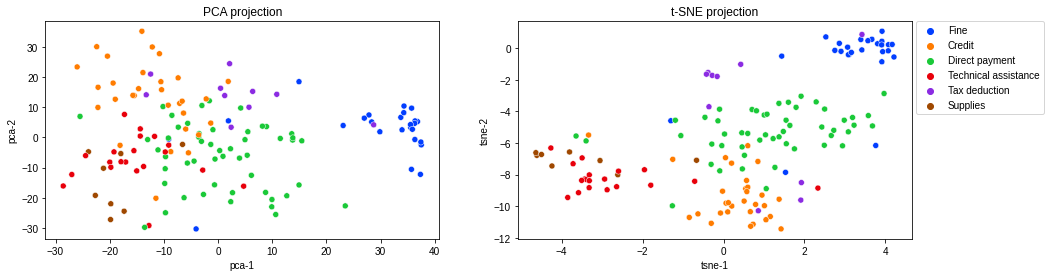

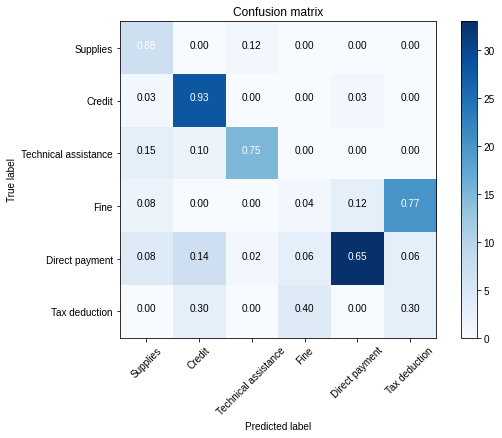

Num epochs: 6



Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 10.37it/s]



Evaluating:  17%|█▋        | 1/6 [00:00<00:00,  9.28it/s]


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  9.94it/s]



Time taken for fine-tuning: 00:00:28.75
Classifying sentences...


100%|██████████| 145/145 [00:04<00:00, 36.21it/s]


[t-SNE] Computing 144 nearest neighbors...
[t-SNE] Indexed 145 samples in 0.001s...
[t-SNE] Computed neighbors for 145 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 145 / 145
[t-SNE] Mean sigma: 9.644842
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.605339
[t-SNE] KL divergence after 1000 iterations: 0.227313


100%|██████████| 145/145 [00:00<00:00, 15111.04it/s]


Stored confusion matrix: /content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/EXPTEST/model=stsb-xlm-r-multilingual_test-perc=0.15_n-epoch=6_cm.png


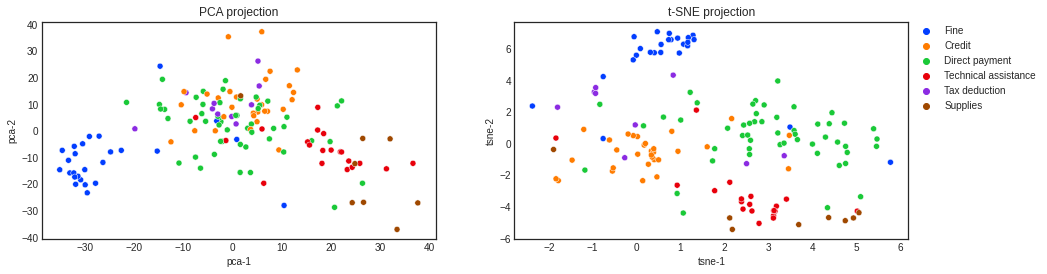

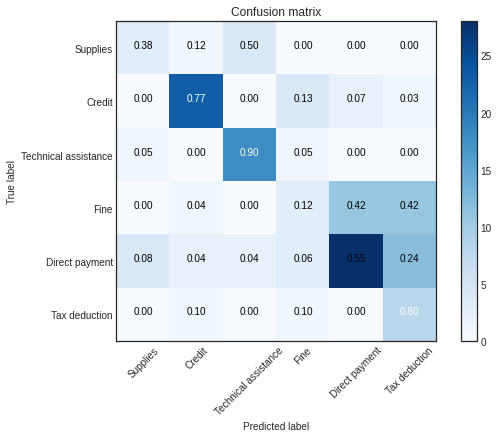

Num epochs: 8



Evaluating:  17%|█▋        | 1/6 [00:00<00:00,  9.47it/s]


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  9.86it/s]


KeyboardInterrupt: ignored

In [ ]:
# Configure the training
all_test_perc = [0.15, 0.2, 0.25, 0.3]
model_names = ['stsb-xlm-r-multilingual', 'paraphrase-xlm-r-multilingual-v1']#, 'quora-distilbert-multilingual''distiluse-base-multilingual-sed-v2', 

# If you want to train for a set number of epochs instead of a range, set all these numbers to be equal
start_epochs = 4
epochs_increment = 2
max_num_epochs = 12

# Output setup - we will update the json as the fine tuning process goes so every result is stored immediately
with open(f"{output_path}{experiment}_FineTuningResults.json", "w") as fw:
  json.dump({}, fw)

for test_perc in all_test_perc:
  with open(f"{output_path}{experiment}_FineTuningResults.json", "r") as fr:
    output = json.load(fr)

  output[f"test_perc={test_perc}"] = {}
  X_train, X_test, y_train, y_test = train_test_split(train_sents, train_labels, test_size=test_perc, stratify=train_labels, random_state=69420)

  # Load data samples into batches
  train_batch_size = 16
  label2int = dict(zip(label_names, range(len(label_names))))
  train_samples = []
  for sent, label in zip(X_train, y_train):
      label_id = label2int[label]
      train_samples.append(InputExample(texts=[sent], label=label_id))

  # Configure the dev set evaluator - still need to test whether this works
  dev_samples = []
  for sent, label in zip(X_test, y_test):
      label_id = label2int[label]
      dev_samples.append(InputExample(texts=[sent], label=label_id))
  
  for model_name in model_names:
    # Setup
    model_preds = []
    model_scores = []
    output[f"test_perc={test_perc}"][model_name] = []
    
    # Train set config
    model = SentenceTransformer(model_name)
    train_dataset = SentencesDataset(train_samples, model=model)
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
    
    # Define the way the loss is computed
    classifier = SoftmaxClassifier(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=len(label2int))
    
    # Dev set config
    dev_dataset = SentencesDataset(dev_samples, model=model)
    dev_dataloader = DataLoader(dev_dataset, shuffle=True, batch_size=train_batch_size)
    dev_evaluator = LabelAccuracyEvaluator(dataloader=dev_dataloader, softmax_model=classifier, name='lae-dev')
        
    for num_epochs in range(start_epochs, max_num_epochs + 2, epochs_increment):
        print("Num epochs:", num_epochs)
        
        warmup_steps = math.ceil(len(train_dataset) * num_epochs / train_batch_size * 0.1)  # 10% of train data for warm-up
        model_deets = f"model={model_name}_test-perc={test_perc}_n-epoch={num_epochs}"

        # Train the model
        start = time.time()
        if num_epochs == start_epochs:
          model.fit(train_objectives=[(train_dataloader, classifier)],
                  evaluator=dev_evaluator,
                  epochs=start_epochs, 
                  evaluation_steps=1000,
                  warmup_steps=warmup_steps,
                  )
        else:
          model.fit(train_objectives=[(train_dataloader, classifier)],
                  evaluator=dev_evaluator,
                  epochs=epochs_increment, # We always tune on an extra epoch to see the performance gain
                  evaluation_steps=1000,
                  warmup_steps=warmup_steps,
                  )
        
        end = time.time()
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        print("Time taken for fine-tuning:", "{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
        
        ### Classify sentences
        # Projection matrix Z low-dim projection
        print("Classifying sentences...")
        proj_matrix = cp.asnumpy(calc_proj_matrix(test_sents, 50, es_nlp, model, 0.01))
        all_sent_embs = encode_train_sents(test_sents, model, proj_matrix)
        all_label_embs = encode_labels(label_names, model, proj_matrix)
        visualize_embeddings_2D(np.vstack(all_sent_embs), test_labels, tsne_perplexity=50, store_name=f"{results_save_path}/{model_deets}")
        model_preds, model_scores = calc_all_cos_similarity(all_sent_embs, all_label_embs, label_names)
        
        ### Evaluate the model
        numeric_preds = labels2numeric(model_preds, label_names)
        evaluator = ModelEvaluator(label_names, y_true=numeric_labels, y_pred=numeric_preds)
        
        output[f"test_perc={test_perc}"][model_name].append({"num_epochs": num_epochs, "avg_f1": evaluator.avg_f1.tolist()})
        with open(f"{output_path}{experiment}_FineTuningResults.json", "w") as fw:
          json.dump(output, fw)

        evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{results_save_path}/{model_deets}")

### Test multiple classifiers
- Random Forests
- Support Vector Machines
- Gradient Boosted trees

### Building datasets

This piece of code below has been used to build the test splits and the datasets for the fine tuning. Don't execute it unless you kow what you want :)

In [ ]:
def labels_from_dataset(dataset, label):
    labels = []

    for sentence in dataset.values():
        labels.append(sentence[label])

    return labels

In [ ]:
rater = "Rater3"
set_of_labels = All
set_of_labels_string = "All"

dataset_fname = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Cristina_Policy_Files/Tagged_sentence_lists/{}_labeled.json".format(rater)
dataset = load_file(dataset_fname)
dataset_map = labeled_sentences_from_dataset(dataset) # Labels AND sentences
# dataset_map_target_labels =  select_labels(dataset_map, set_of_labels) # Adjust to the labels you want to use for your analysis. In the cell above you have three pre-defined sets.
# train_sents = sentences_from_dataset(dataset_map_target_labels) # Just sentences
# train_labels = labels_from_dataset(dataset_map_target_labels, "labels") # Just labels. 

train_sents = sentences_from_dataset(dataset_map) # Just sentences
train_labels = labels_from_dataset(dataset_map, "incentive") # Just labels.

In [ ]:
len(train_labels)

1526

In [ ]:
# # The rest:
label_names = unique_labels(train_labels)
numeric_labels = labels2numeric(train_labels, label_names)
label_names

['Supplies',
 'Technical assistance',
 'Direct payment',
 'Fine',
 'Tax deduction',
 'Credit']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_sents, train_labels, test_size=0.2, stratify=train_labels, random_state=69420)

In [ ]:
# import csv
path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Cristina_Policy_Files/Tagged_sentence_lists/datasets/"

filename = "dataset_{}_incentive_sentences.csv".format(rater)
file = path + filename
with open(file, 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(X_train)

filename = "dataset_{}_incentive_labels.csv".format(rater)
file = path + filename
with open(file, 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(y_train)

filename = "testset_{}_incentive_sentences.csv".format(rater)
file = path + filename
with open(file, 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(X_test)

filename = "testset_{}_incentive_labels.csv".format(rater)
file = path + filename
with open(file, 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(y_test)


In [ ]:
# import csv
path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Cristina_Policy_Files/Tagged_sentence_lists/datasets/"

filename = "dataset_{}_{}_sentences.csv".format(rater, set_of_labels_string)
file = path + filename
with open(file, 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(X_train)

filename = "dataset_{}_{}_labels.csv".format(rater, set_of_labels_string)
file = path + filename
with open(file, 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(y_train)

filename = "testset_{}_{}_sentences.csv".format(rater, set_of_labels_string)
file = path + filename
with open(file, 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(X_test)

filename = "testset_{}_{}_labels.csv".format(rater, set_of_labels_string)
file = path + filename
with open(file, 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(y_test)
